# SimpleConf

> Performs updating of state-action values according to a simple Rescorla-Wagner rule, with use of social information. Allows for asymmetric learning rates in the form of a confirmation/disconfirmation bias. 

In [ ]:
#| default_exp agents/SimpleConf

In [ ]:
#| hide
# Imports for the nbdev development environment

from nbdev.showdoc import *
from fastcore.test import *

# Imports for examples

import matplotlib.pyplot as plt

In [ ]:
#| hide

%load_ext autoreload
%autoreload 2

In [ ]:
#| export

import numpy as np
import networkx as nx

In [ ]:
#| export

class SimpleConf(object):
    """
    Class for simple reinforcement learning (Rescorla-Wagner rule)
    with confirmation/disconfirmation bias.
    """

    def __init__(self, 
                 params: np.ndarray):  # agents' parameters
        
        self.N = np.shape(params)[0]  # number of agents
        self.M = 2  # number of options
        self.alphac = params[:, 0]   # confirmatory learning rates
        self.alphad = params[:, 1]   # disconfirmatory learning rates
        self.beta = params[:, 2]    # inverse temperatures

    def connect_agents_full(self):
        """Connects agents according to a fully connected graph."""
        return nx.complete_graph(self.N)

    def compute_softmax(self, Qtable):
        """Returns a probability table for all agents for all actions,
        from agents' Qtable."""
        beta = np.row_stack(self.beta)
        num = np.exp(beta*Qtable)  # numerator
        den = np.sum(num, axis=1)  # denominator
        return num/den[:, None]

    def choose(self, Ptable):
        """Computes chosen options from agents's probability table."""
        choices = np.zeros((np.shape(Ptable)[0]))  # 1 choice per agent
        rd = np.reshape(np.random.rand(len(choices)), (len(choices), 1))
        # a random number between 0 and 1 is attributed to each agent
        choices = np.sum(rd > np.cumsum(Ptable, axis=1), axis=1) # if 
        # random number is smaller than agent's probability of choosing 0,
        # then agent chooses 0
        choices = choices.astype(int)  # converts the choices to int values
        return choices
    
    def all_take_action(self, Qtable):
        """Computes all agents' choices from their Qtable.
        Combines `compute_softmax` and `choose`.
        """
        Ptable = self.compute_softmax(Qtable)  # converts Q-values to
        # policy via softmax function
        choices = self.choose(Ptable)  # choose an option according to
        # policy
        return choices
    
    def update_Qvalues(self, G_att, choices, payoffs, Qtable): 
        """Updates all agents' Q-values according to CARL."""
        Qs = np.einsum('ijk->ikj', np.reshape(np.repeat(Qtable, self.N), 
                                              (self.N, self.M, self.N)))
        Rs = np.einsum('ijk->kij', np.reshape(np.repeat(np.repeat(payoffs, 
                                                                  self.N), 
                                                        self.M), 
                                              (self.N, self.M, self.N)))
        # dimensions: own Q-values, options, others' actions
        deltas = Rs - Qs  # prediction errors
        alphac_cube = np.reshape(np.repeat(self.alphac, self.N*self.M), 
                                 (self.N, self.N, self.M))
        alphad_cube = np.reshape(np.repeat(self.alphad, self.N*self.M), 
                                 (self.N, self.N, self.M))
        # 3d matrices with only confirmatory alphas vs. disconfirmatory
        # alphas
        pos = deltas > 0  # mask that indicates where pred errors are 
        # positive
        ags = np.arange(0, self.N, 1)  # vector of agent indices
        # choice_mask selects all actions that have been taken
        choice_mask = np.zeros((self.N, self.N, self.M)).astype(bool)
        choice_mask[:, ags, choices] = True
        deltas[~choice_mask] = 0
        # own_mask selects actions per agent
        own_mask = np.zeros((self.N, self.N, self.M)).astype(bool)
        own_mask[ags, :, choices] = True
        # same_act selects actions similar to my actions
        same_act = choice_mask & own_mask
        # other_act selects actions different from mine
        other_act = choice_mask & ~own_mask
        same_pos = pos & same_act
        other_pos = pos & other_act
        same_neg = ~pos & same_act
        other_neg = ~pos & other_act
        # alphas determines which alpha to attribute to each pred error
        alphas = np.zeros((self.N, self.N, self.M))
        alphas[same_pos] = alphac_cube[same_pos]
        alphas[same_neg] = alphad_cube[same_neg]
        alphas[other_neg] = alphac_cube[other_neg]
        alphas[other_pos] = alphad_cube[other_pos] 
        # obs_mask selects actions that I observe
        obs_ij = np.asarray(nx.adjacency_matrix(G_att).todense()).astype(bool)
        obs_mask = np.reshape(np.repeat(obs_ij, self.M), (self.N, self.N, 
                                                          self.M))
        np.fill_diagonal(obs_ij, True)  # I observe my own actions
        obs_mask[:, :, 0] = obs_ij
        obs_mask[:, :, 1] = obs_ij
        deltas[~obs_mask] = 0  # cancelled pred errors from unobserved actions
        # update Q-values according to CARL model
        deltas *= alphas
        deltas_sum = np.sum(deltas, axis=1)
        Qtable += deltas_sum
        return Qtable

## Example agents

To illustrate the methods, let's consider 2 example agents. Both have a confirmation bias. Their parameters are the following:

|         | $\alpha_C$ | $\alpha_D$ | $\beta$ |
| --------| ---------- | ---------- | ------- |
| agent 1 | $0.2$      | $0.1$      | $5.$     |
| agent 2 | $0.15$     | $0.05$     | $4.$     |

* $\alpha_C$: confirmatory learning rate
* $\alpha_D$: disconfirmatory learning rate
* $\beta$: inverse temperature

In [ ]:
# Define example agents
params = np.array([[0.2, 0.1, 5.],  # agent 1's params
                   [0.15, 0.05, 4.]])  # agent 2's params

example = SimpleConf(params)

## SimpleConf methods

In [ ]:
show_doc(SimpleConf.connect_agents_full)

---

### SimpleConf.connect_agents_full

>      SimpleConf.connect_agents_full ()

Connects agents according to a fully connected graph.

**Input**:

* None

**Output**:

* Fully connected, non-directed "attention graph": each agent pays attention to all others.


#### Example

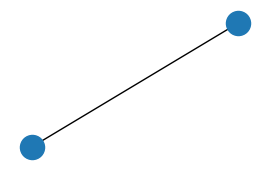

In [ ]:
# Connecting example agents
G = example.connect_agents_full()

# Draw graph
plt.figure(figsize=(2.5, 1.5))
nx.draw(G)
plt.show()

In [ ]:
show_doc(SimpleConf.compute_softmax)

---

### SimpleConf.compute_softmax

>      SimpleConf.compute_softmax (Qtable)

Returns a probability table for all agents for all actions,
from agents' Qtable.

**Input**: 
* `Qtable`: Q-table, 2d-array: *number of agents* $\times$ *number of options*

|         | option 1  | option 2  |
| --------| --------- | --------- |
| agent 1 | $Q_{1,1}$ | $Q_{1,2}$ |
| agent 2 | $Q_{2,1}$ | $Q_{2,2}$ |


**Output**:
* `Ptable`: P-table, 2d-array: *number of agents* $\times$ *number of options*

|         | option 1  | option 2  |
| --------| --------- | --------- |
| agent 1 | $P_{1,1}$ | $P_{1,2}$ |
| agent 2 | $P_{2,1}$ | $P_{2,2}$ |



#### Softmax policy

Probability that agent $i$ chooses option $j$ given Q-values $Q_{i,k}$, for $k$ any available option:

$$ P_{i,j} = \frac{exp(\beta_{i} Q_{i,j})}{\sum_{k} exp(\beta_{i} Q_{i,k})} $$

with $\beta_{i}$ agent $i$'s inverse temperature.



#### Example

With 2 agents, 2 options, all Qs are 0.

In [ ]:
Qtable = np.zeros((2, 2))
Ptable = example.compute_softmax(Qtable)
Ptable

array([[0.5, 0.5],
       [0.5, 0.5]])

In [ ]:
show_doc(SimpleConf.choose)

---

[source](https://github.com/clembergerot/CARL/blob/main/CARL/agents/SimpleConf.py#L38){target="_blank" style="float:right; font-size:smaller"}

### SimpleConf.choose

>      SimpleConf.choose (Ptable)

Computes chosen options from agents's probability table.

**Input**:

* `Ptable`: P-table, 2d-array: *number of agents* $\times$ *number of options*

|         | option 1  | option 2  |
| --------| --------- | --------- |
| agent 1 | $P_{1,1}$ | $P_{1,2}$ |
| agent 2 | $P_{2,1}$ | $P_{2,2}$ |


**Output**:

* `choices`: choice (i.e., chosen option) list, 1d-array: *number of agents*

|         | choice  | 
| --------| ------- | 
| agent 1 | $c_{1}$ | 
| agent 2 | $c_{2}$ | 


NB: options are labelled $0$ to $M-1$, with $M$ number of available options.


#### Example

In [ ]:
# Compute example agents' choices according to previous Ptable
choices = example.choose(Ptable)
choices

array([0, 0])

In [ ]:
# Test: given option labelling, over many simulations, average
# choice should approach probability of choosing option 1
choices_test = np.zeros((2, 10000))
for i in range(10000):  # loop over simulations
    choices_test[:, i] = example.choose(Ptable)
    
np.mean(choices_test, axis=1)  # compute average

array([0.5149, 0.5091])

In [ ]:
show_doc(SimpleConf.all_take_action)

---

[source](https://github.com/clembergerot/CARL/blob/main/CARL/agents/SimpleConf.py#L46){target="_blank" style="float:right; font-size:smaller"}

### SimpleConf.all_take_action

>      SimpleConf.all_take_action (Qtable)

Computes all agents' choices from their Qtable.
Combines `compute_softmax` and `choose`.

**Input**:

* `Qtable`: Q-table, 2d-array: *number of agents* $\times$ *number of options*

|         | option 1  | option 2  |
| --------| --------- | --------- |
| agent 1 | $Q_{1,1}$ | $Q_{1,2}$ |
| agent 2 | $Q_{2,1}$ | $Q_{2,2}$ |


**Output**:

* `choices`: choice (i.e., chosen option) list, 1d-array: *number of agents*

|         | choice  | 
| --------| ------- | 
| agent 1 | $c_{1}$ | 
| agent 2 | $c_{2}$ | 


#### Example

In [ ]:
# Compute example agents' choices according to previous Qtable
choices = example.all_take_action(Qtable)
choices

array([0, 1])

In [ ]:
# Test: given option labelling, over many simulations, average
# choice should approach probability of choosing option 1
choices_test = np.zeros((2, 10000))
for i in range(10000):  # loop over simulations
    choices_test[:, i] = example.all_take_action(Qtable)
    
np.mean(choices_test, axis=1)  # compute average

array([0.509 , 0.4981])

In [ ]:
show_doc(SimpleConf.update_Qvalues)

---

[source](https://github.com/clembergerot/CARL/blob/main/CARL/agents/SimpleConf.py#L54){target="_blank" style="float:right; font-size:smaller"}

### SimpleConf.update_Qvalues

>      SimpleConf.update_Qvalues (G_att, choices, payoffs, Qtable)

Updates all agents' Q-values according to CARL.

**Input**:

* `G_att`: attention graph, obtained through `connect_agents_full`
* `choices`: choice (i.e., chosen option) list, 1d-array: *number of agents*

|         | choice  | 
| --------| ------- | 
| agent 1 | $c_{1}$ | 
| agent 2 | $c_{2}$ | 

* `payoffs`: payoff list returned by task, 1d-array: *number of agents*

|         | payoff  | 
| --------| ------- | 
| agent 1 | $r_{1}$ | 
| agent 2 | $r_{2}$ | 

* `Qtable`: Q-table, 2d-array: *number of agents* $\times$ *number of options*

|         | option 1  | option 2  |
| --------| --------- | --------- |
| agent 1 | $Q_{1,1}$ | $Q_{1,2}$ |
| agent 2 | $Q_{2,1}$ | $Q_{2,2}$ |



**Output**:
* `Qtable`: updated Q-table, 2d-array: *number of agents* $\times$ *number of options*

|         | option 1  | option 2  |
| --------| --------- | --------- |
| agent 1 | $Q_{1,1}$ | $Q_{1,2}$ |
| agent 2 | $Q_{2,1}$ | $Q_{2,2}$ |


**Example**


In [ ]:
# Update previous Q-values given following payoffs:
payoffs = np.array([-1, 1])  # first agent got -1, second got 1
example.update_Qvalues(G, choices, payoffs, Qtable)  # update Q-values

array([[-0.1 ,  0.1 ],
       [-0.15,  0.15]])

In [ ]:
#| hide
# import nbdev; nbdev.nbdev_export()